In [33]:
import ast
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud
from collections import Counter
import nltk
import squarify
from nltk.corpus import stopwords

In [18]:
df = pd.read_csv("data/traficogt_clean.csv")
df.columns.tolist()

['fecha_gt',
 'hora_gt',
 'anio',
 'mes_num',
 'mes_nombre',
 'dia_semana',
 'hora',
 'id',
 'user.username',
 'rawContent',
 'replyCount',
 'retweetCount',
 'likeCount',
 'quoteCount',
 'date',
 'user.id',
 'mentionedUsers',
 'clean_text',
 'mentions',
 'datetime_utc',
 'datetime_gt',
 'dia']

# Construcción del grafo dirigido

In [19]:
def parse_list(s):
    if isinstance(s, str):
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else []
        except Exception:
            return []
    return []

pairs = []  

for _, r in df.iterrows():
    u = str(r["user.username"]).lower().strip()

    # menciones
    for v in parse_list(r.get("mentions")):
        v = str(v).lower().strip()
        if v and u and u != v:
            pairs.append((u, v, "mention"))

edge_counts = Counter((u, v) for u, v, _ in pairs)
edge_types   = Counter((u, v, t) for u, v, t in pairs)

len(edge_counts), len(edge_types)


(7335, 7335)

In [20]:
G = nx.DiGraph()
for (u, v), w in edge_counts.items():
    G.add_edge(u, v, weight=w)

nodes_df = pd.DataFrame({"user": list(G.nodes())})
edges_df = pd.DataFrame([(u, v, d["weight"]) for u, v, d in G.edges(data=True)],
                        columns=["source","target","weight"])

nodes_df.to_csv("data/nodes.csv", index=False)
edges_df.to_csv("data/edges.csv", index=False)

G.number_of_nodes(), G.number_of_edges()


(2720, 7335)

In [21]:
W_MIN = 0       
K_CORE = 5      
TOP_LABELS = 30 

# aristas débiles
H = nx.DiGraph(((u, v, d) for u, v, d in G.edges(data=True) if d.get("weight",1) >= W_MIN))

# componente gigante
UG = H.to_undirected()
giant = H.subgraph(max(nx.connected_components(UG), key=len)).copy()

# k-core en no dirigido
core_nodes = nx.k_core(giant.to_undirected(), k=K_CORE).nodes()
H = giant.subgraph(core_nodes).copy()

H.number_of_nodes(), H.number_of_edges()


(459, 2774)

In [22]:
deg = dict(H.degree())
btw = nx.betweenness_centrality(H.to_undirected(), k=min(1000, H.number_of_nodes()), seed=42)

top_nodes = sorted(deg, key=deg.get, reverse=True)[:TOP_LABELS]
node_size = [max(80, deg[n]*10) for n in H.nodes()]
edge_width = [0.5 + H[u][v]["weight"]*0.25 for u, v in H.edges()]


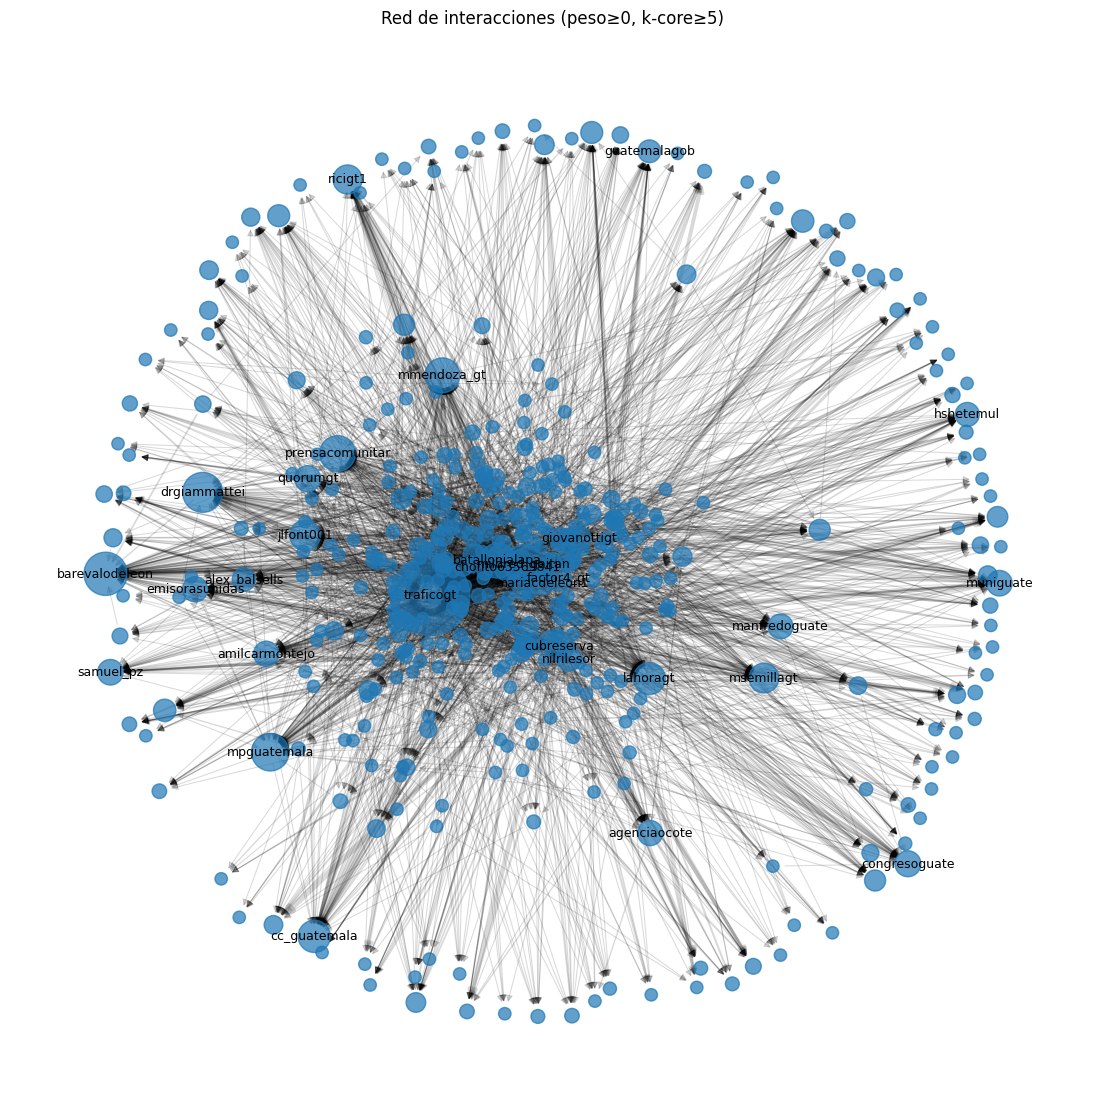

In [23]:
pos = nx.spring_layout(H, k=0.35, iterations=100, seed=7)

plt.figure(figsize=(14,14))
nx.draw_networkx_edges(H, pos, alpha=0.15, arrows=True, width=edge_width)
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color="tab:blue", alpha=0.7)
nx.draw_networkx_labels(H, pos, labels={n:n for n in top_nodes}, font_size=9)
plt.title(f"Red de interacciones (peso≥{W_MIN}, k-core≥{K_CORE})")
plt.axis("off")
plt.show()


La red con `W_MIN=0` y `k-core=5` muestra un **núcleo central muy denso** donde destacan cuentas como **@traficogt, @prensacomunitar, @drgiammattei, @amilcarmontejo** y **@muniguate**, que concentran la mayoría de interacciones y funcionan como **hubs de información**. Alrededor de ellas se forman comunidades más pequeñas, mientras que los usuarios periféricos mantienen conexiones limitadas. Esto evidencia que la conversación está fuertemente centralizada en pocos actores influyentes que articulan y amplifican la discusión pública sobre el tráfico en Guatemala.


# Metricas

In [24]:
densidad = nx.density(H)  

HU = H.to_undirected()
if nx.is_connected(HU):
    diametro = nx.diameter(HU)
else:
    comp = HU.subgraph(max(nx.connected_components(HU), key=len)).copy()
    diametro = nx.diameter(comp)

clustering = nx.average_clustering(HU)

print(f"Densidad: {densidad:.5f}")
print(f"Diámetro: {diametro}")
print(f"Coeficiente de agrupamiento: {clustering:.4f}")


Densidad: 0.01320
Diámetro: 4
Coeficiente de agrupamiento: 0.1842


La red presenta una densidad de 0.0132, lo que indica que solo una pequeña fracción de los enlaces posibles está presente; es una red dispersa, como suele ocurrir en interacciones de twitter. El diámetro de 4 muestra que cualquier usuario puede llegar a otro en muy pocos pasos, evidenciando una red relativamente eficiente en la propagación de información. Finalmente, el coeficiente de agrupamiento de 0.1842 señala que existen clústeres locales donde los usuarios tienden a interactuar dentro de grupos, reforzando la presencia de comunidades en torno a ciertos actores centrales.

# Comunidades y “relaciones de poder”

In [25]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(H.to_undirected()))
len(communities), [len(c) for c in communities[:5]]

(9, [132, 96, 95, 81, 19])

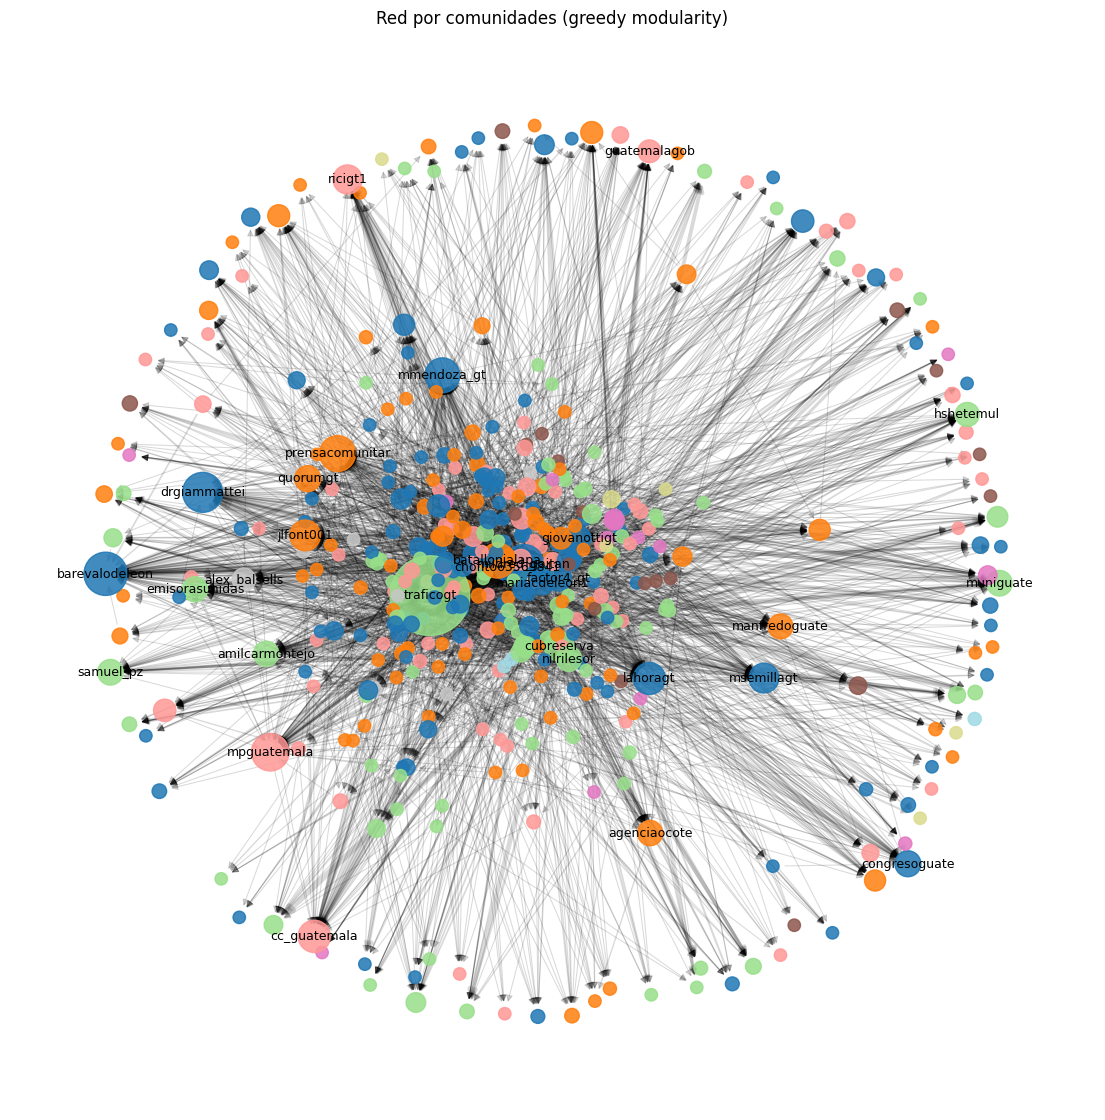

In [26]:
comm_index = {}
for i, com in enumerate(communities):
    for n in com:
        comm_index[n] = i

colors = [comm_index.get(n, -1) for n in H.nodes()]
plt.figure(figsize=(14,14))
nx.draw_networkx_edges(H, pos, alpha=0.15, arrows=True, width=edge_width)
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color=colors, cmap="tab20", alpha=0.85)
nx.draw_networkx_labels(H, pos, labels={n:n for n in top_nodes}, font_size=9)
plt.title("Red por comunidades (greedy modularity)")
plt.axis("off")
plt.show()

El análisis de comunidades mediante **greedy modularity** reveló **9 grupos principales** de usuarios, con tamaños que van desde 132 hasta 19 miembros. Esto muestra que la red, aunque concentrada en un núcleo central, se organiza en **subgrupos cohesivos** alrededor de cuentas influyentes como actores políticos, medios y autoridades. En estos clústeres los usuarios interactúan más entre sí que con el resto de la red, lo que refleja **audiencias diferenciadas** y focos de conversación específicos dentro del tema general del tráfico en Guatemala.

# Top 3 Cmounidades

c:\Users\josue\uvg\Semestre 8\data science\social-networks\another-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


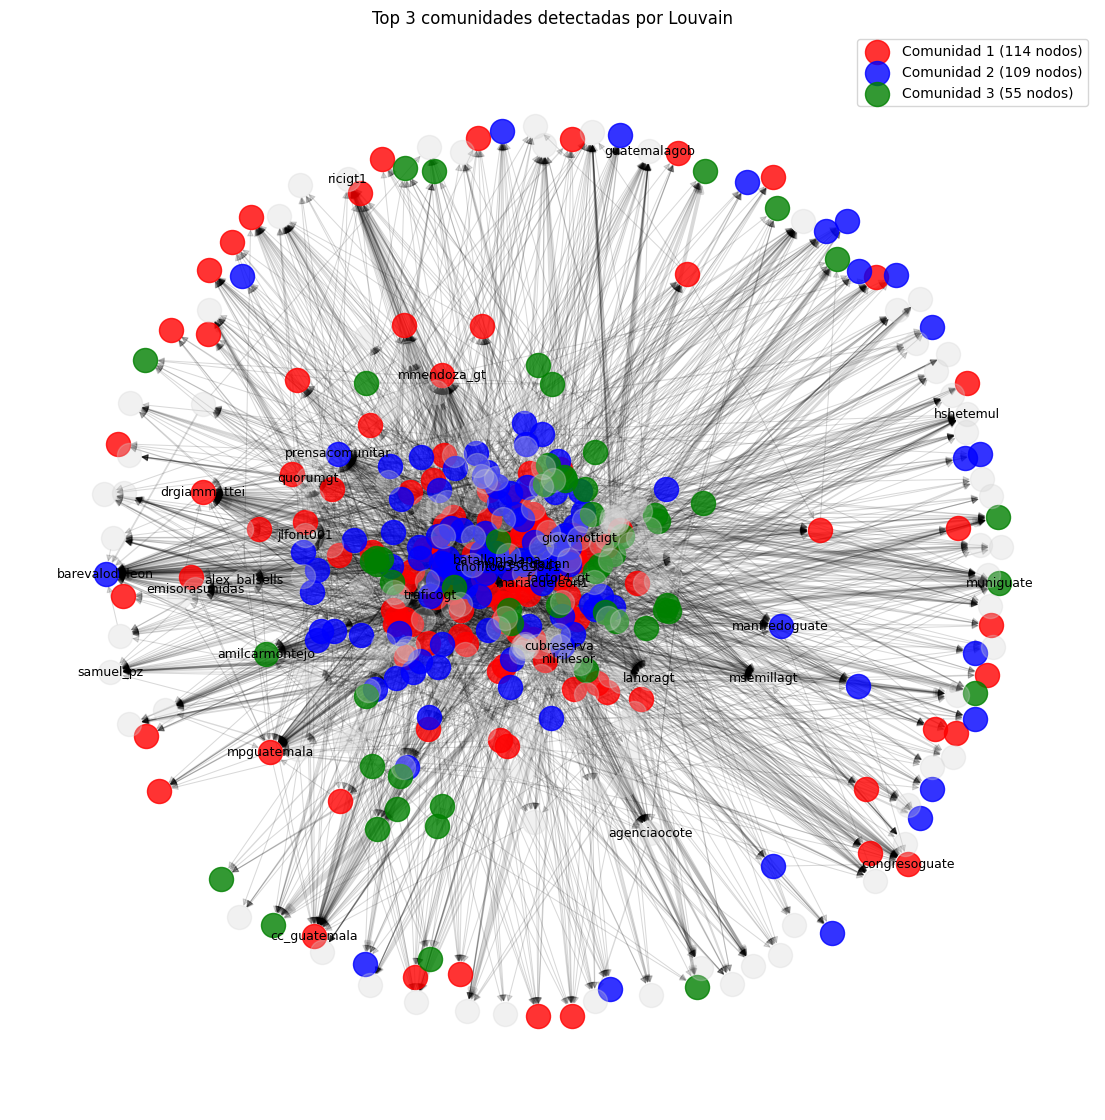

Comunidad 1:
  Tamaño: 114 nodos
  Interacciones: 329 enlaces

Comunidad 2:
  Tamaño: 109 nodos
  Interacciones: 348 enlaces

Comunidad 3:
  Tamaño: 55 nodos
  Interacciones: 155 enlaces



In [27]:

import community.community_louvain as community_louvain
# Aplica Louvain sobre el grafo H (no dirigido)
louvain_partition = community_louvain.best_partition(H.to_undirected())
louvain_partition = community_louvain.best_partition(H.to_undirected())
import collections
louvain_communities = collections.defaultdict(list)
for node, comm in louvain_partition.items():
    louvain_communities[comm].append(node)

# Ordena comunidades por tamaño y selecciona las 3 más grandes
top3_louvain = sorted(louvain_communities.items(), key=lambda x: len(x[1]), reverse=True)[:3]

# Visualización
top_colors = ['red', 'blue', 'green']
plt.figure(figsize=(14,14))
for i, (comm_id, nodes) in enumerate(top3_louvain):
    nx.draw_networkx_nodes(H, pos, nodelist=nodes, node_color=top_colors[i], label=f'Comunidad {i+1} ({len(nodes)} nodos)', alpha=0.8)
other_nodes = [n for n in H.nodes if louvain_partition[n] not in [c[0] for c in top3_louvain]]
nx.draw_networkx_nodes(H, pos, nodelist=other_nodes, node_color='lightgray', alpha=0.3)
nx.draw_networkx_edges(H, pos, alpha=0.15, arrows=True, width=edge_width)
nx.draw_networkx_labels(H, pos, labels={n:n for n in top_nodes}, font_size=9)
plt.title('Top 3 comunidades detectadas por Louvain')
plt.legend()
plt.axis('off')
plt.show()

# Caracterización de las 3 comunidades más grandes
for i, (comm_id, nodes) in enumerate(top3_louvain):
    subgraph = H.subgraph(nodes)
    size = len(nodes)
    interactions = subgraph.number_of_edges()
    print(f"Comunidad {i+1}:")
    print(f"  Tamaño: {size} nodos")
    print(f"  Interacciones: {interactions} enlaces")
    # Si tienes temas en los atributos, aquí puedes analizarlos
    print()

# Temas de conversación por comunidad

Comunidad 1 - Temas principales:
['guatemala', 'si', 'corruptos', 'presidente', 'solo', 'mp', 'ser', 'q', 'así', 'millones']


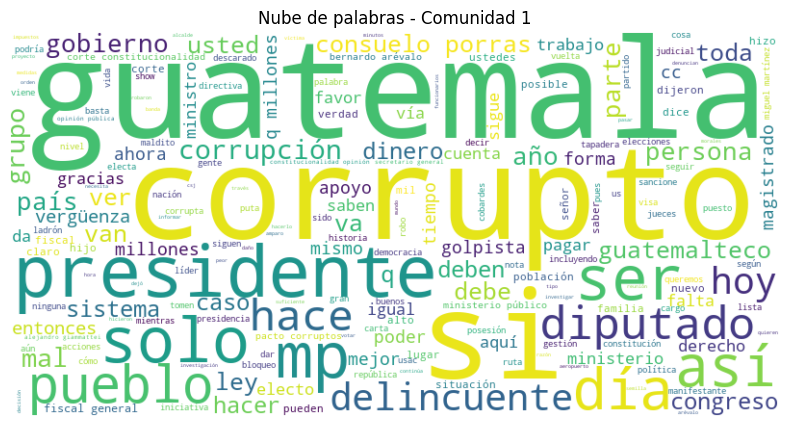

Comunidad 2 - Temas principales:
['si', 'solo', 'corruptos', 'guatemala', 'pueblo', 'ahora', 'mp', 'ser', 'cc', 'q']


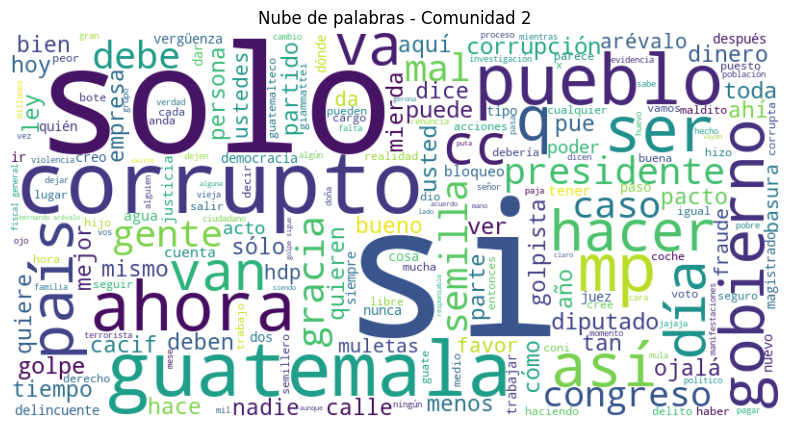

Comunidad 3 - Temas principales:
['zona', 'calle', 'villa', 'hacia', 'tráfico', 'avenida', 'av', 'nueva', 'paso', 'vía']


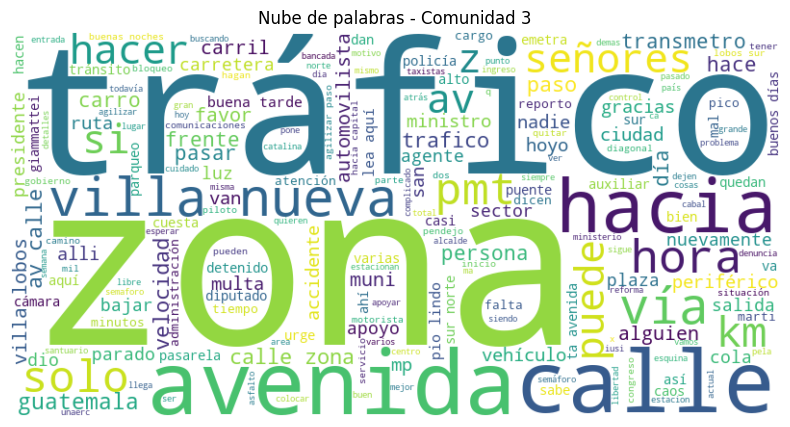

In [28]:
# --- Temas principales de conversación por comunidad (Louvain) ---

# Descargar stopwords si es necesario
try:
    stop_words = set(stopwords.words('spanish'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('spanish'))

for i, (comm_id, nodes) in enumerate(top3_louvain):
    # Filtra los textos de los usuarios en la comunidad
    textos = df[df['user.username'].str.lower().isin(nodes)]['clean_text'].dropna().astype(str)
    all_words = ' '.join(textos).lower().split()
    words_filtered = [w for w in all_words if w.isalpha() and w not in stop_words]
    word_counts = Counter(words_filtered)
    top_words = word_counts.most_common(10)
    print(f"Comunidad {i+1} - Temas principales:")
    print([w for w, _ in top_words])
    # Nube de palabras
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words_filtered))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras - Comunidad {i+1}')
    plt.show()


# Análisis de influencers y nodos clave

Top 10 usuarios por centralidad de grado:
traficogt: 0.7183
barevalodeleon: 0.2118
drgiammattei: 0.1812
mildred_gaitan: 0.1790
mpguatemala: 0.1594
prensacomunitar: 0.1463
batallonjalapa: 0.1397
mmendoza_gt: 0.1376
cc_guatemala: 0.1179
lahoragt: 0.1157


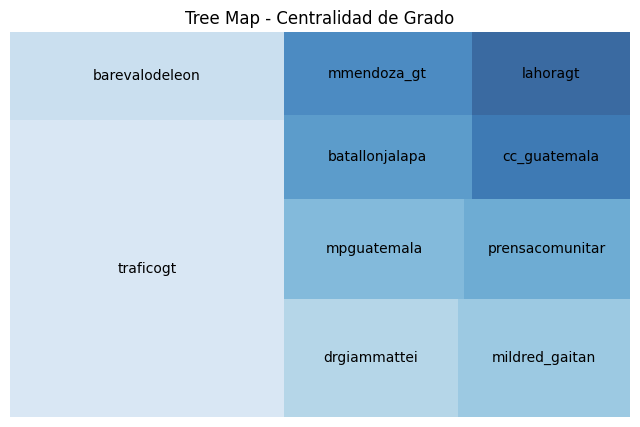


Top 10 usuarios por centralidad de intermediación:
traficogt: 0.6221
mildred_gaitan: 0.0533
barevalodeleon: 0.0383
batallonjalapa: 0.0349
drgiammattei: 0.0269
mpguatemala: 0.0251
prensacomunitar: 0.0180
mmendoza_gt: 0.0153
cubreserva: 0.0122
cc_guatemala: 0.0120


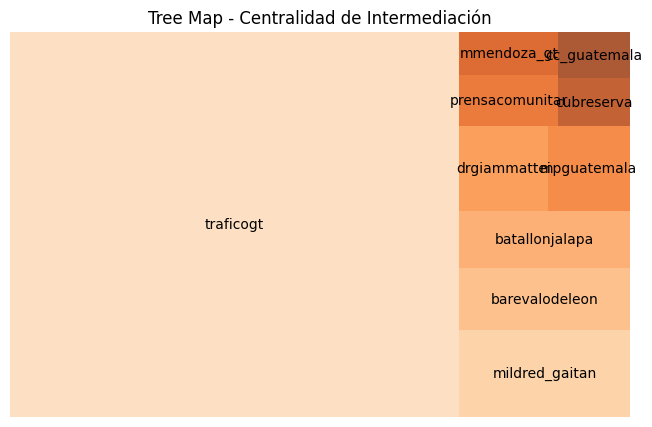


Top 10 usuarios por centralidad de cercanía:
traficogt: 0.6528
barevalodeleon: 0.4086
mpguatemala: 0.3883
drgiammattei: 0.3868
mmendoza_gt: 0.3639
lahoragt: 0.3579
msemillagt: 0.3573
congresoguate: 0.3554
jlfont001: 0.3509
emisorasunidas: 0.3460


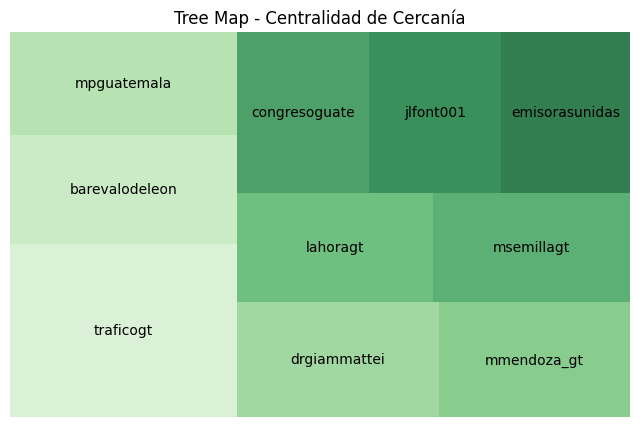

In [34]:
# --- Análisis de influencers y nodos clave ---

# Centralidad de grado (más conexiones directas)
degree_centrality = nx.degree_centrality(H)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 usuarios por centralidad de grado:")
for user, score in top_degree:
    print(f"{user}: {score:.4f}")

# Tree map para centralidad de grado
users, scores = zip(*top_degree)
plt.figure(figsize=(8,5))
squarify.plot(sizes=scores, label=users, color=plt.cm.Blues([0.2 + 0.8*i/len(scores) for i in range(len(scores))]), alpha=0.8)
plt.title('Tree Map - Centralidad de Grado')
plt.axis('off')
plt.show()

# Centralidad de intermediación (puentes entre comunidades)
betweenness_centrality = nx.betweenness_centrality(H.to_undirected(), k=min(1000, H.number_of_nodes()), seed=42)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 usuarios por centralidad de intermediación:")
for user, score in top_betweenness:
    print(f"{user}: {score:.4f}")

# Tree map para centralidad de intermediación
users_b, scores_b = zip(*top_betweenness)
plt.figure(figsize=(8,5))
squarify.plot(sizes=scores_b, label=users_b, color=plt.cm.Oranges([0.2 + 0.8*i/len(scores_b) for i in range(len(scores_b))]), alpha=0.8)
plt.title('Tree Map - Centralidad de Intermediación')
plt.axis('off')
plt.show()

# Centralidad de cercanía (menor cantidad de saltos)
closeness_centrality = nx.closeness_centrality(H)
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 usuarios por centralidad de cercanía:")
for user, score in top_closeness:
    print(f"{user}: {score:.4f}")

# Tree map para centralidad de cercanía
users_c, scores_c = zip(*top_closeness)
plt.figure(figsize=(8,5))
squarify.plot(sizes=scores_c, label=users_c, color=plt.cm.Greens([0.2 + 0.8*i/len(scores_c) for i in range(len(scores_c))]), alpha=0.8)
plt.title('Tree Map - Centralidad de Cercanía')
plt.axis('off')
plt.show()


# Detección y análisis de grupos aislados

In [36]:
# --- Análisis de subredes y nodos aislados ---

# Encuentra los componentes conectados en el grafo no dirigido
UG = H.to_undirected()
components = list(nx.connected_components(UG))

# Componente gigante (el más grande)
giant_component = max(components, key=len)

# Subredes aisladas: componentes pequeños (por ejemplo, menos de 10 nodos)
isolated_subnets = [c for c in components if len(c) < 10]

print(f"Total de componentes: {len(components)}")
print(f"Componente gigante: {len(giant_component)} nodos")
print(f"Subredes aisladas (menos de 10 nodos): {len(isolated_subnets)}")

# Analiza cada subred aislada
for i, subnet in enumerate(isolated_subnets[:5]):  # Muestra hasta 5 subredes
    subgraph = UG.subgraph(subnet)
    print(f"\nSubred aislada {i+1}:")
    print(f"  Nodos: {list(subnet)}")
    print(f"  Número de nodos: {len(subnet)}")
    print(f"  Número de enlaces: {subgraph.number_of_edges()}")
    # Si quieres ver los textos asociados:
    usuarios = list(subnet)
    textos = df[df['user.username'].str.lower().isin(usuarios)]['clean_text'].dropna().astype(str)
    print(f"  Temas principales: {', '.join(textos.head(3))}")

    # Visualización de la subred
    pos_sub = nx.spring_layout(subgraph, seed=42)
    plt.figure(figsize=(4,4))
    nx.draw(subgraph, pos_sub, with_labels=True, node_color='lightcoral', edge_color='gray', node_size=400)
    plt.title(f'Subred aislada {i+1}')
    plt.show()

Total de componentes: 1
Componente gigante: 459 nodos
Subredes aisladas (menos de 10 nodos): 0


El resultado indica que la red tiene solo un componente conectado (el gigante) y no existen subredes aisladas con menos de 10 nodos. Esto significa que todos los nodos están conectados directa o indirectamente entre sí, formando una sola red grande y cohesionada.



# Análisis de contenido y sentimiento

Total de tweets analizados: 5596
Positivos: 99 (1.8%)
Negativos: 50 (0.9%)
Neutrales: 5447 (97.3%)


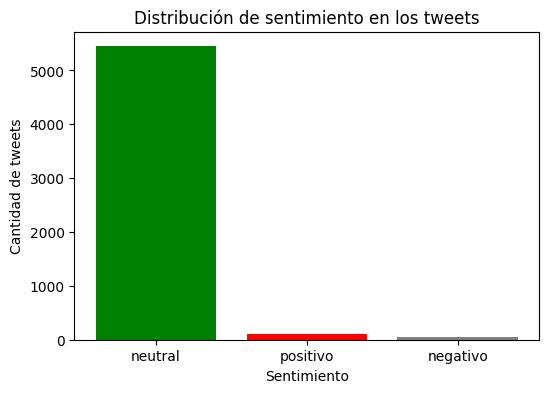

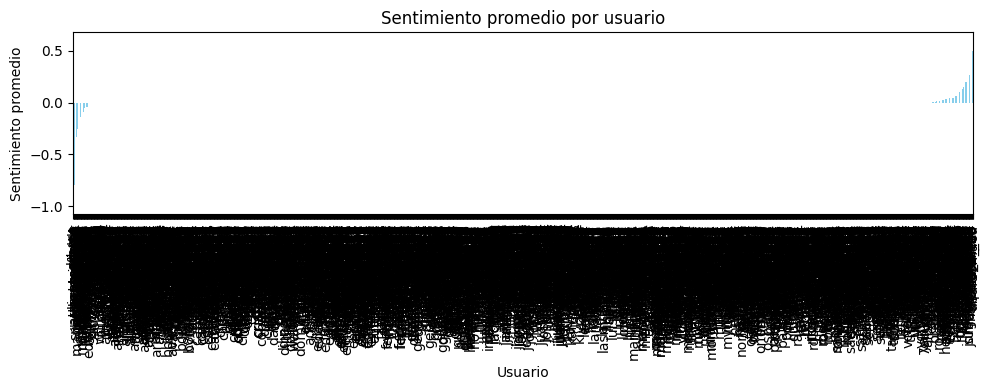

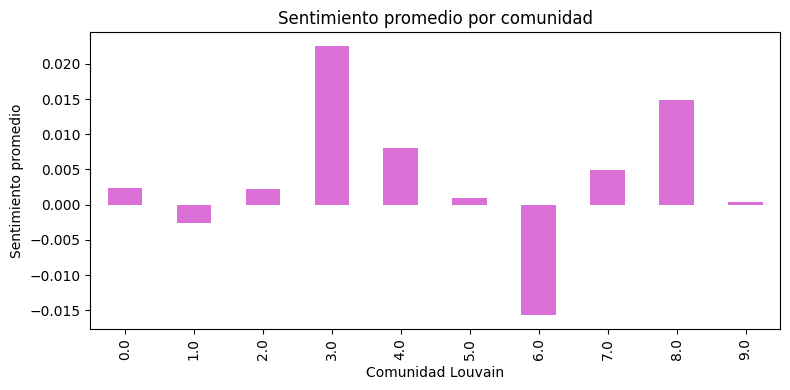

In [ ]:
# --- Análisis de sentimiento de los tweets ---

from textblob import TextBlob
import matplotlib.pyplot as plt

# Función para obtener el sentimiento
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarityS
    except:
        return 0

# Aplica el análisis de sentimiento
df['sentiment'] = df['clean_text'].astype(str).apply(get_sentiment)

# Clasifica el sentimiento
df['sentiment_label'] = df['sentiment'].apply(
    lambda x: 'positivo' if x > 0.1 else ('negativo' if x < -0.1 else 'neutral')
)

# Estadísticas generales
total = len(df)
pos = (df['sentiment_label'] == 'positivo').sum()
neg = (df['sentiment_label'] == 'negativo').sum()
neu = (df['sentiment_label'] == 'neutral').sum()
print(f"Total de tweets analizados: {total}")
print(f"Positivos: {pos} ({pos/total:.1%})")
print(f"Negativos: {neg} ({neg/total:.1%})")
print(f"Neutrales: {neu} ({neu/total:.1%})")

# Visualización de la distribución
data = df['sentiment_label'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(data.index, data.values, color=['green','red','gray'])
plt.title('Distribución de sentimiento en los tweets')
plt.ylabel('Cantidad de tweets')
plt.xlabel('Sentimiento')
plt.show()

# Sentimiento promedio por usuario
user_sentiment = df.groupby('user.username')['sentiment'].mean().sort_values()
plt.figure(figsize=(10,4))
user_sentiment.plot(kind='bar', color='skyblue')
plt.title('Sentimiento promedio por usuario')
plt.ylabel('Sentimiento promedio')
plt.xlabel('Usuario')
plt.tight_layout()
plt.show()

if 'louvain_partition' in globals():
    df['comunidad'] = df['user.username'].str.lower().map(louvain_partition)
    comunidad_sentiment = df.groupby('comunidad')['sentiment'].mean()
    plt.figure(figsize=(8,4))
    comunidad_sentiment.plot(kind='bar', color='orchid')
    plt.title('Sentimiento promedio por comunidad')
    plt.ylabel('Sentimiento promedio')
    plt.xlabel('Comunidad Louvain')
    plt.tight_layout()
    plt.show()

Los resultados muestran que la gran mayoría de los tweets (97.3%) tienen un sentimiento neutral, mientras que solo el 1.8% son positivos y el 0.9% negativos.

Esto puede deberse a varias razones:

- **Lenguaje informativo:** Los usuarios suelen compartir información objetiva sobre el tráfico, sin expresar emociones fuertes.
- **Limitaciones del análisis:** TextBlob es una herramienta sencilla y puede no captar matices, sarcasmo o contexto local, clasificando muchos textos como neutrales.
- **Temática del dataset:** El tema principal (tráfico) tiende a generar mensajes descriptivos y poco emocionales.
En resumen, la conversación en la red es mayormente neutral y objetiva, con pocos mensajes que expresan emociones positivas o negativas.